## In this notebook, you will learn how to use TensorRT to quantize a ResNet18 ONNX model. 

     Before the beginning, please go over the previous training videos and slides.
     If you have already watched the corresponding training video and slides, you can skip this step.


### Some key points need to be known

1. TensorRT only supports symmetric and uniform quantization. So, it means that -|max|=|max| and some values Saturate above |threshold| to 127 will be truncated.
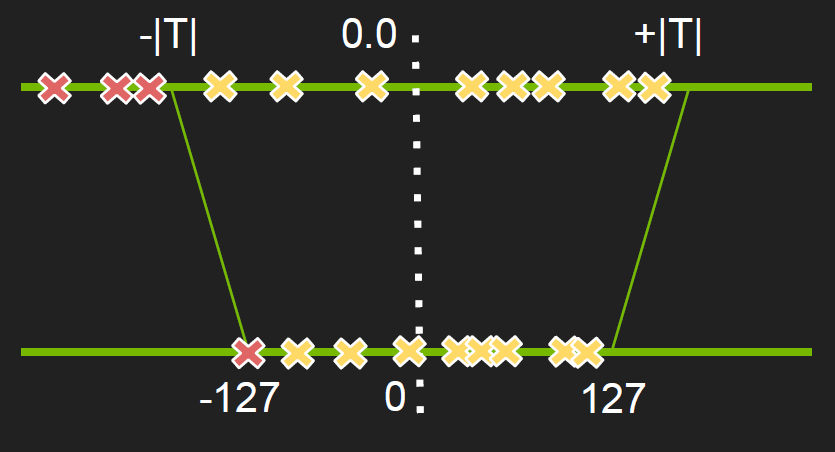


2. Quantizing a layer means quantize the inputs and weights of this layer. Whether quantizing the outputs of this layer depends on the layer type and next layer/OP.So the quantization of output is not included in this layer.
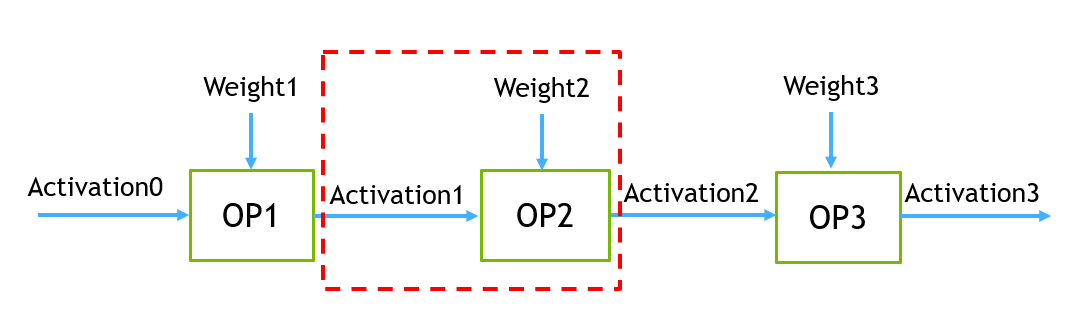



3. To calculate the truncation position of activations, TensorRT provides four algorithms as listed below.You can select one in the calibrator.
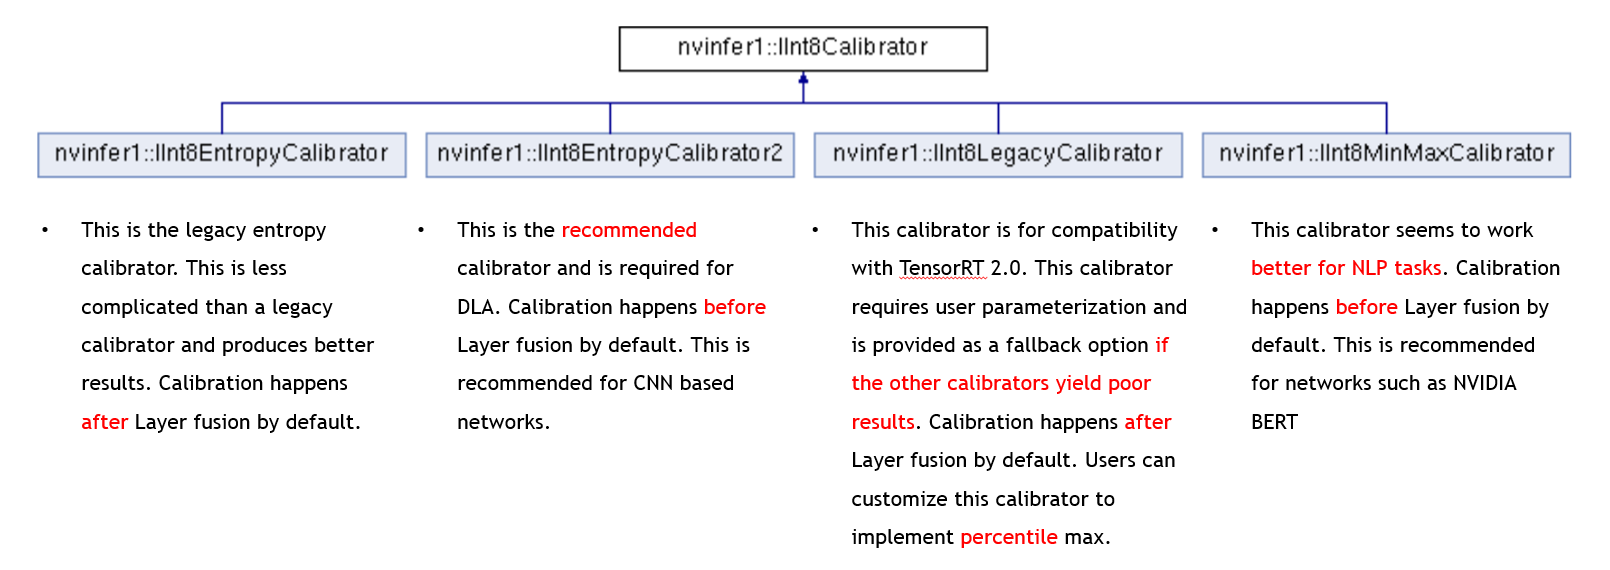


4. If you are not satisfied with accuracy after quanztization, you can fallback some layers to higher precision (FP16/FP32). You also can change the dynamic ranges (scale number, stored in calibration cache) into other values those you got by other method.


### When running the following code cells, three important key points need to be paid attention.
1. How to write a calibrator.
2. How to implement a partial quantization (fallback some layers to FP32 precision).
3. How to manually set the dynamic range for the specified activation


### First of all, we need to install and load some requirements.

In [1]:
!pip install -r requirements.txt
!python3 -m pip install onnx_graphsurgeon --index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.ngc.nvidia.com


### Now, let us start!
Firstly, since the orignal resnet18.onnx contains unfolded constants, we use polygraphy to simplify the onnx model!

In [2]:
!polygraphy surgeon sanitize resnet18_dynamic_batch.onnx --fold-constants -o resnet18_new_dynamic_batch.onnx

[I] Loading model: /tmp/tmp_polygraphy_6ee88c73814115a010dbd99aa4eb13e6424f97cdd0172b9d.onnx
[I] Original Model:
    Name: torch-jit-export | Opset: 12
    
    ---- 1 Graph Input(s) ----
    {input_0 [dtype=float32, shape=('batch', 3, 32, 32)]}
    
    ---- 1 Graph Output(s) ----
    {output_0 [dtype=float32, shape=('batch', 10, 1, 1)]}
    
    ---- 42 Initializer(s) ----
    
    ---- 48 Node(s) ----
    
[I] Folding Constants | Pass 1
[I]     Total Nodes | Original:    48, After Folding:    48 |     0 Nodes Folded
[I] Saving ONNX model to: resnet18_new_dynamic_batch.onnx
[I] New Model:
    Name: torch-jit-export | Opset: 12
    
    ---- 1 Graph Input(s) ----
    {input_0 [dtype=float32, shape=('batch', 3, 32, 32)]}
    
    ---- 1 Graph Output(s) ----
    {output_0 [dtype=float32, shape=('batch', 10, 1, 1)]}
    
    ---- 42 Initializer(s) ----
    
    ---- 48 Node(s) ----
    


### Import the libs/packages we will use later.

In [3]:
import tensorrt as trt
import numpy as np
import pickle
import struct

# For our custom calibrator
from calibrator import MNISTEntropyCalibrator

# For ../common.py
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], os.path.pardir))
import common

TRT_LOGGER = trt.Logger()

### Define functions for data loading. This function will be used for accuracy check (inference).

In [4]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict


def batch_data_Normalize(batch_data, mean_list=[0.4914, 0.4822, 0.4465], std_list=[0.2023, 0.1994, 0.2010]):
    for i in range(batch_data.shape[0]):
        batch_data[i, 0, :, :] = (batch_data[i, 0, :, :] - mean_list[0]) / std_list[0]
        batch_data[i, 1, :, :] = (batch_data[i, 1, :, :] - mean_list[1]) / std_list[1]
        batch_data[i, 2, :, :] = (batch_data[i, 2, :, :] - mean_list[2]) / std_list[2]
    return batch_data


def load_cifar_data(cifar10_path):
    testXtr = unpickle(cifar10_path + "test_batch")
    images = np.vstack(testXtr['data']).reshape(-1, 3, 32, 32) / 255
    images = batch_data_Normalize(images)
    images = np.ascontiguousarray((images).astype(np.float32))
    labels = np.array(testXtr['labels'])
    labels = np.ascontiguousarray(labels.astype(np.int32).reshape(-1))
    return images, labels

### check_accuracy function will be used to check the accuracy of the quantized model.

In [5]:
def check_accuracy(context, batch_size, test_set, test_labels):
    inputs, outputs, bindings, stream = common.allocate_buffers(context)
    num_correct = 0
    num_total = 0
    print('test_set.shape[0]', test_set.shape[0])
    batch_num = 0
    for start_idx in range(0, test_set.shape[0], batch_size):
        batch_num += 1
        if batch_num % 100 == 0:
            print("Validating batch {:}".format(batch_num))
        # If the number of images in the test set is not divisible by the batch size, the last batch will be smaller.
        # This logic is used for handling that case.
        end_idx = min(start_idx + batch_size, test_set.shape[0])
        effective_batch_size = end_idx - start_idx

        # Do inference for every batch.
        inputs[0].host = test_set[start_idx:start_idx + effective_batch_size]
        [output] = common.do_inference(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream,
                                       batch_size=effective_batch_size)
        # Use argmax to get predictions and then check accuracy
        preds = np.argmax(output[0:effective_batch_size * 10].reshape(effective_batch_size, 10), axis=1)
        labels = test_labels[start_idx:start_idx + effective_batch_size]
        # print(preds)
        # print(labels)
        # print()
        num_total += effective_batch_size
        num_correct += np.count_nonzero(np.equal(preds, labels))
    percent_correct = 100 * num_correct / float(num_total)
    print("Total Accuracy: {:}%".format(percent_correct))

### Convert the cache file into a readable format
After quantization finished, we will get a quantization cache file which includes activations' scale values of quantized layers. The value in the cache file is HEX format which is not readable. So, we can use this 'read_calib_cache' function to convert the HEX format into int value.

In [6]:
def read_calib_cache(cache_file):
    if os.path.exists(cache_file):
        result_dict = {}
        with open(cache_file) as f:
            for line in f:
                line_split_n = line.split('\n')
                line_split = line_split_n[0].split(':')
                if len(line_split)>1:
                    #tensor_name = line_split[0]
                    #scale = line_split[1]
                    result_dict[line_split[0]] = line_split[1]
        f.close()
        return result_dict
    else:
        print('cache is not existed!')
        return None

### Then we build the TensorRT engine by using 'build_int8_engine' function. The building steps can be listed as below:
0. Set the workspace size, max_batch_size, EXPLICIT_BATCH, etc.
1. Set the precision flag such as trt.BuilderFlag.FP16 or trt.BuilderFlag.INT8.
2. If we set the precision flag into INT8, we need to write a calibrator which will tell TensorRT:
    a. What calibration algorithm we use;
    b. How to load the calibration data;
    b. How to write and read the calibration cache.
3. Using the ONNX parser to import the ONNX model into TensorRT network
4. Set the input of the network. (input can be set as dynamic shape)
5. If we use INT8 precision, we can manually change the model quantization:
    a. We can fallback some layers into FP32 precision;
    b. We can change the scale/dynamic range of INT8 layers' output activation.
6. Then, we use 'builder.build_engine()' to build the engine.The calibrator will be called during the building process.

### Here, we also have two TODO tasks for self testing:
1. Please try to fallback the last 1 conv layers into fp32 precision.
2. Please try to set all activation (Relu) layers' output range into [-6, 6].

In [7]:
# This function builds an engine from a Caffe model.
def build_int8_engine(onnx_file_path, calib, batch_size, calibration_cache):
    # with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, builder.create_builder_config() as config, trt.CaffeParser() as parser:
    EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network(common.EXPLICIT_BATCH) as network, \
            builder.create_builder_config() as config, trt.OnnxParser(network,TRT_LOGGER) as parser:
        # We set the builder batch size to be the same as the calibrator's, as we use the same batches
        # during inference. Note that this is not required in general, and inference batch size is
        # independent of calibration batch size.
        builder.max_batch_size = batch_size

        config.max_workspace_size = common.GiB(1)
        config.set_flag(trt.BuilderFlag.INT8)
        config.set_flag(trt.BuilderFlag.STRICT_TYPES)
        config.int8_calibrator = calib

        # Parse Onnx model
        with open(onnx_file_path, 'rb') as model:
            print('Beginning ONNX file parsing')
            if not parser.parse(model.read()):
                print('ERROR: Failed to parse the ONNX file.')
                for error in range(parser.num_errors):
                    print(parser.get_error(error))
                return None
        
        # For the fixed batch, please use the following code
        network.get_input(0).shape = [batch_size, 3, 32, 32]
        
        # For dynamic batch, please use the following code
        ### TODO 3: Using the dynamic shapes way to support the dynamic batch for engine building, inference and calibration.

        
        #Decide which layers fallback to FP32. #I f all layers fallback to FP32, you can use 'index>-1'
        for index, layer in enumerate(network):
            #print('layer index', index, ':', layer.type, layer.name) # This print can help you to learn the info of each layer.
            if index < 10:
                if layer.type == trt.LayerType.ACTIVATION or \
                        layer.type == trt.LayerType.CONVOLUTION or \
                        layer.type == trt.LayerType.FULLY_CONNECTED or \
                        layer.type == trt.LayerType.SCALE:
                    print('layer index', index, ':', layer.type, 'will be', 'fallback to fp32!')
                    layer.precision = trt.float32
                    layer.set_output_type(0, trt.float32)
                    
        ### setting dynamic range for the output of activation layer
        ### here, we set the output of layer[64] ReLu to [-6, 6]
        layer=network[45]
        tensor = layer.get_output(0)
        tensor.dynamic_range = (-6.0, 6.0)
        
        ### TODO 1: Please fallback the last 1 conv layers into fp32 precision ###  
        
        ### TODO 2: Please set all activation layers' output range into [-6, 6] ###


        # Start to build engine and do int8 calibration.
        print('--- Starting to build engine! ---')
        engine = builder.build_engine(network, config)
        print('--- Building engine is finished! ---')
        
        ### Using the calibration cache to pick out correspondding network layer
        cache_dict = read_calib_cache(calibration_cache)
        if cache_dict is not None:
            for index, layer in enumerate(network):
                for i in range(layer.num_outputs):
                    output_tensor = layer.get_output(i)
                    if output_tensor.name in cache_dict:
                        hex_str = cache_dict[output_tensor.name]                    
                        scale = struct.unpack('!f', bytes.fromhex(hex_str))[0]
                        
                        ### this print is to show the dynamic ranges / scales of the calibration cache
                        #print('Layer index is:', index, '; ', \
                        #      'Activations dynamic range is: (-/+)', scale * 127.0, '; ',\
                        #      'Layer type is:', layer.type)#, ';', \
                        #      #'output tensor name is:', output_tensor.name)
        return engine

In [8]:
#import common
ONNX_PATH = "resnet18_new_dynamic_batch.onnx"
cifar10_data_path = './cifar10_data/'
calib_data_path = './cifar10_data/calib_dataset_40/'
batch_size = 32

# Now we create a calibrator and give it the location of our calibration data.
# We also allow it to cache calibration data for faster engine building.
calibration_cache = "mnist_calibration.cache"
calib = MNISTEntropyCalibrator(calib_data_path, total_images=40, batch_size=batch_size, cache_file=calibration_cache)

 # This is inference batch size that can be different from calibration batch size.
with build_int8_engine(ONNX_PATH, calib, batch_size, calibration_cache) as engine, engine.create_execution_context() as context:                       
    context.active_optimization_profile = 0  # For dynamic shapes
    context.set_binding_shape(0, (batch_size, 3, 32, 32))  # For dynamic shapes
    
    # Batch size for inference can be different than batch size used for calibration.
    test_set, test_labels = load_cifar_data(cifar10_data_path)
    check_accuracy(context, batch_size, test_set=test_set, test_labels=test_labels)

total_images: 40 ; calib_images shape: (40, 3, 32, 32)
Beginning ONNX file parsing
layer index 0 : LayerType.CONVOLUTION will be fallback to fp32!
layer index 1 : LayerType.ACTIVATION will be fallback to fp32!
layer index 3 : LayerType.CONVOLUTION will be fallback to fp32!
layer index 4 : LayerType.ACTIVATION will be fallback to fp32!
layer index 5 : LayerType.CONVOLUTION will be fallback to fp32!
layer index 7 : LayerType.ACTIVATION will be fallback to fp32!
layer index 8 : LayerType.CONVOLUTION will be fallback to fp32!
layer index 9 : LayerType.ACTIVATION will be fallback to fp32!
--- Starting to build engine! ---


/tmp/ipykernel_3350/66720457.py:66: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


Calibrating batch 0, containing 32 images
Calibration is finished!


[TensorRT] WARNING: Detected invalid timing cache, setup a local cache instead
[TensorRT] WARNING: No implementation of layer Conv_47 obeys the requested constraints in strict mode. No conforming implementation was found i.e. requested layer computation precision and output precision types are ignored, using the fastest implementation.
/tmp/ipykernel_3350/4253709756.py:14: DeprecationWarning: Use set_optimization_profile_async instead.
  context.active_optimization_profile = 0  # For dynamic shapes


--- Building engine is finished! ---
test_set.shape[0] 10000
Validating batch 100
Validating batch 200
Validating batch 300
Total Accuracy: 88.88%


### Questions

#### Here are some tasks you can do for the further self testing.
1. Try to write you own calibrator to load other calibration dataset. (eg. using more calibration image to see the effect on acc)
2. Try to quantizate a model you encountered in your daily customer engagement work.

Answers:

In [ ]:
### TODO 1: Please fallback the last 1 conv layers into fp32 precision ###
network[43].precision = trt.float32
network[43].set_output_type(0, trt.float32)        


### TODO 2: Please set all activation layers' output range into [-6, 6] ###
for index, layer in enumerate(network):
    if index > 0:
        if layer.type == trt.LayerType.ACTIVATION:
            tensor = layer.get_output(0)
            tensor.dynamic_range = (-6.0, 6.0)


### TODO 3: Using the dynamic shapes way to support the dynamic batch for engine building, inference and calibration.
profile = builder.create_optimization_profile();
profile.set_shape("input_0", (1, 3, 32, 32), (batch_size, 3, 32, 32), (batch_size, 3, 32, 32))
config.add_optimization_profile(profile)
config.set_calibration_profile(profile)


### TODO 4: Select another calibration algorithm in the calibrator
class MNISTEntropyCalibrator(trt.IInt8MinMaxCalibrator):
    def __init__(self, training_data, cache_file, total_images, batch_size=1):
        # Whenever you specify a custom constructor for a TensorRT class,
        # you MUST call the constructor of the parent explicitly.
        trt.IInt8MinMaxCalibrator.__init__(self)